# TCLab_OLP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from datetime import datetime
import tclab
import time

import os

import package_DBR
from package_DBR import myRound

# Function used for interaction with TCLab

In [2]:
def experiment(MV0,DV0,Delta,Ts,SlopePVLim,SlopePVTime,StepTime,ExpVariable,ExpType):
    
    global i, t, MV, PV, DV, Exp, SlopePV, TimerSlopePV, TwoSteps, SecondExperiment
    Tf = 1 # Parameter for slope computation of PV
    
    t.append(i*Ts)
    
    def set_TCLab(MVValue,DVValue):
        lab.Q1(MVValue)
        lab.Q2(DVValue)
        MV.append(MVValue)
        DV.append(DVValue)        
    
    if ExpType == 'Preheating':
        SecondExperiment = False
        if ExpVariable == "MV":
            set_TCLab(MV0-Delta,DV0)
        elif ExpVariable == "DV":
            set_TCLab(MV0,DV0-Delta)
        else:
            print("Not a known experiment !")
            set_TCLab(MV0,DV0)
    elif ExpType == 'StepExperiment':
        if ExpVariable == "MV":
            if (t[-1] < StepTime) or SecondExperiment:
                set_TCLab(MV0-Delta,DV0)
            else:
                set_TCLab(MV0+Delta,DV0)                
        elif ExpVariable == "DV":
            if (t[-1] < StepTime) or SecondExperiment:            
                set_TCLab(MV0,DV0-Delta)
            else:
                set_TCLab(MV0,DV0+Delta)                
        else:
            print("Not a known experiment variable !")
            set_TCLab(MV0,DV0)           
    else:
        print("Not a known experiment type !")
        set_TCLab(MV0,DV0)        
        
    PV.append(lab.T1);
    
    if i > 1:
        SlopePV = (Tf/(Tf + Ts))*SlopePV + (1/(Tf + Ts))*(PV[-1] - PV[-2])
    else:
        TimerSlopePV = SlopePVTime + 1
    
    l1.set_data(t,MV)
    l2.set_data(t,PV)
    l3.set_data(t,DV)
    
    clear_output(wait=True)
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    
    if i > 1:
        ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
        ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
        ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)        
    
    display(fig)        
    
    print('PV [°C]: ' + str(PV[-1]) + ', SlopePV [°C/s]: ' + str(SlopePV))
    
    i = i + 1
    time.sleep(Ts)
    
    if (abs(SlopePV) < SlopePVLim):
        TimerSlopePV = TimerSlopePV - 1;
    else:
        TimerSlopePV = SlopePVTime + 1
        
    if TimerSlopePV == 0:
        if (ExpType == 'StepExperiment') and TwoSteps:
            TwoSteps = False
            SecondExperiment = True
            TimerSlopePV = SlopePVTime + 1
        else:
            Exp = False
            if ExpType == 'StepExperiment':
                now = datetime.now()
                date_time = now.strftime("%Y-%m-%d-%Hh%M")
                t = np.array(t)
                MV = np.array(MV)
                PV = np.array(PV)
                DV = np.array(DV)
                my_data = np.vstack((t.T,MV.T,PV.T,DV.T))
                my_data = my_data.T
                nameFile = 'Data/Open_loop_experiment_on_' + ExpVariable + '_' + date_time + '.txt'
                if not os.path.exists('Data'):
                    os.makedirs('Data')
                np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,PV,DV',comments='')
                    
    return SlopePV, TimerSlopePV

# Experimentation parameters

In [5]:
Ts = 1 #temps echantillonage

ExpVariable = "DV" #remplacer par "DV" pour passer sur l'exo 2

MV0 = 50
DV0 = 50

# MV0 - Delta to MV0 + Delta if Experiment = "MV"
# DV0 - Delta to DV0 + Delta if Experiment = "DV"
Delta = 20 # tester avec d'autres valeurs (si trop petit, le bruit cache, si trop grand, on s'éloingne du point de fonctionnement)

# Change on PV < SlopePVLim for SlopePVTime before taking step
SlopePVLim = 0.07 #trouver le pt de fonctionnement, si la pente est de 0.07 pendant un vertain moment(si trop de briut, diminuer le temps de la pente ou chnger la valeur de la pente--> 0.07 vers 0.1)
SlopePVTime = 20

# Step time during experiment
StepTime = 10 # temps de détectetion de ???

# Twosteps ?
TwoSteps = True

# Real-time visualition of the experimental signals

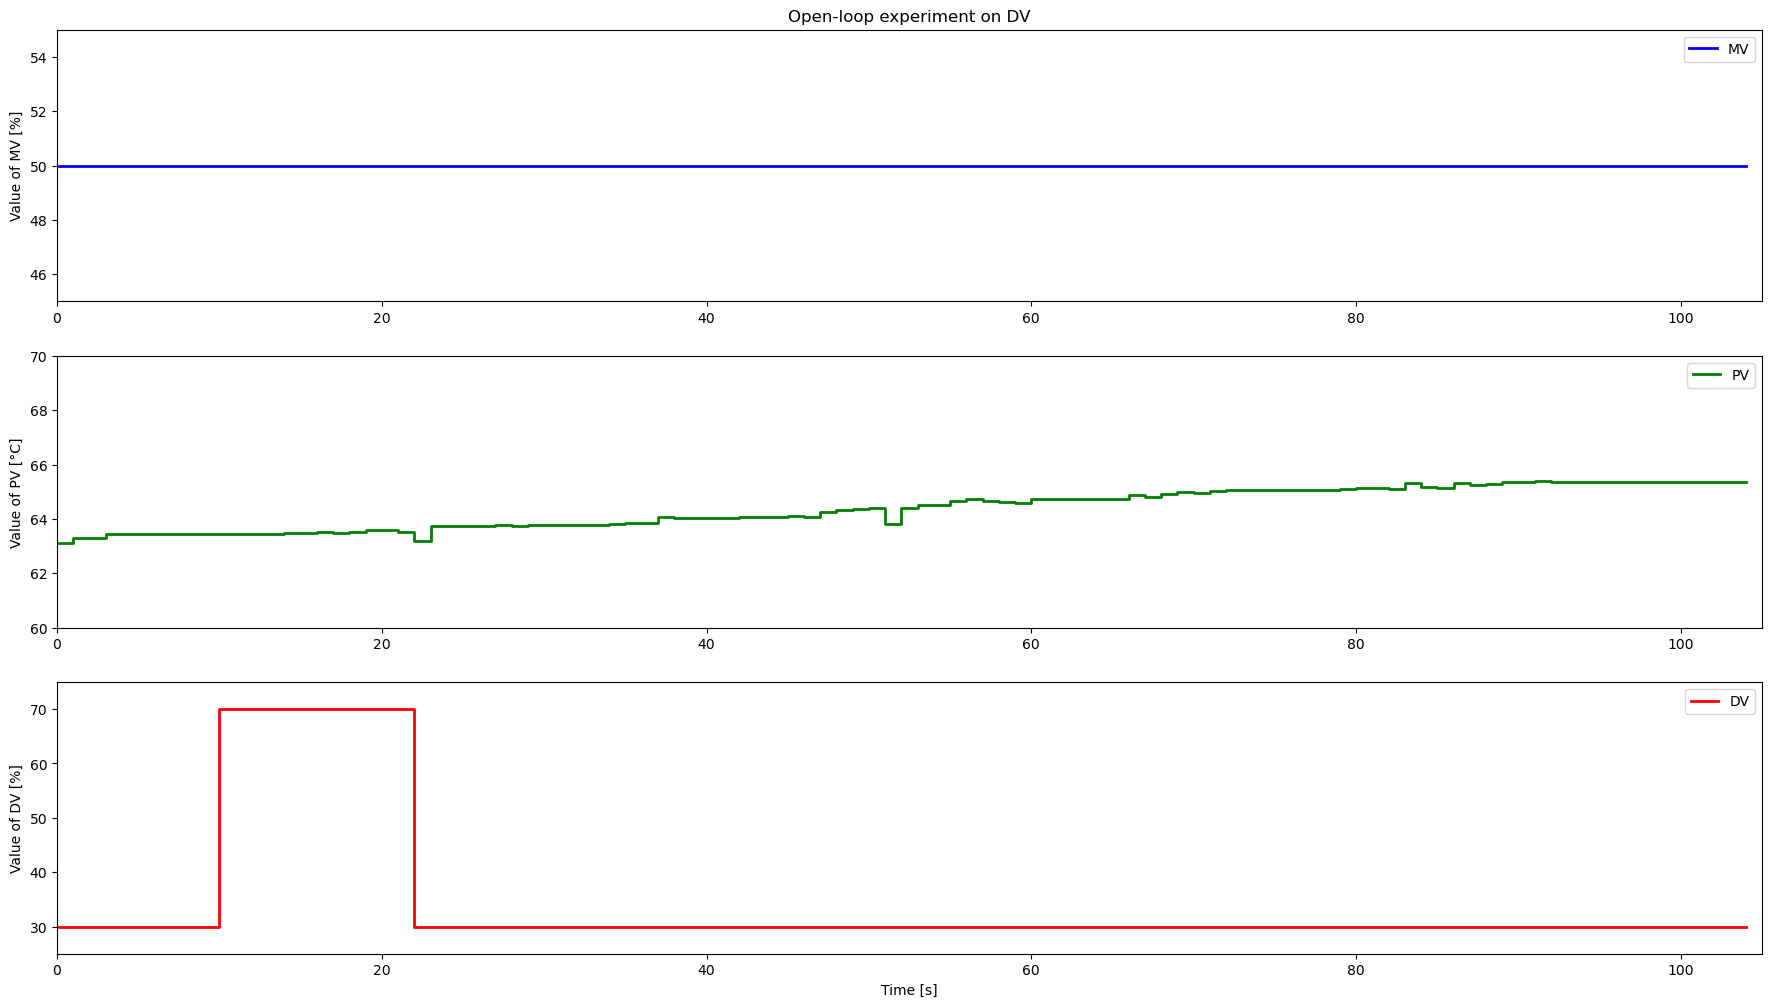

PV [°C]: 65.37, SlopePV [°C/s]: -8.409940761183756e-08
TCLab disconnected successfully.


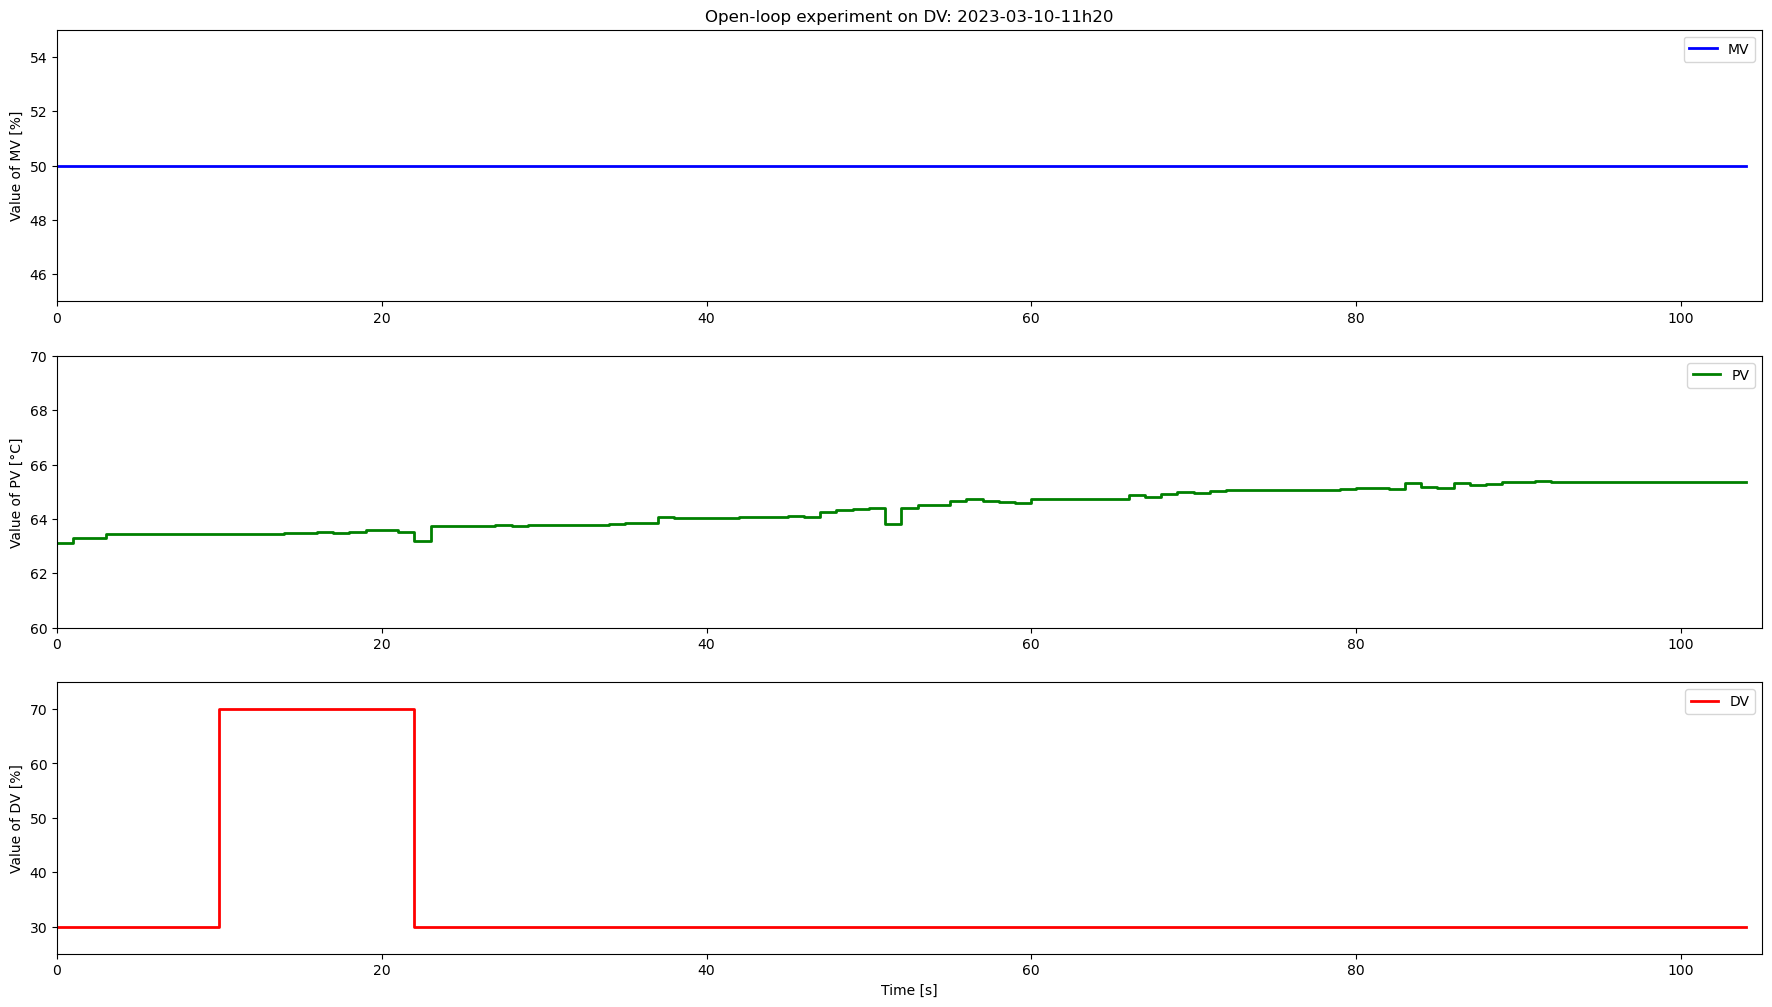

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Open-loop experiment on ' + ExpVariable)
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best') 

lab = tclab.TCLab()

t = []
i = 0
MV = []
DV = []
PV = []
Exp = True
SlopePV = 0

while Exp:
    experiment(MV0,DV0,Delta,Ts,SlopePVLim,SlopePVTime,StepTime,ExpVariable,'Preheating')

t = []
i = 0
MV = []
DV = []
PV = []
Exp = True
SlopePV = 0

while Exp:
    experiment(MV0,DV0,Delta,Ts,SlopePVLim,SlopePVTime,StepTime,ExpVariable,'StepExperiment')
    
lab.close() # Disconnect from TCLab

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
ax1.set_title('Open-loop experiment on ' + ExpVariable + ': ' + date_time)
nameFile = 'Plots/Open_Loop_Experiment_on_' + ExpVariable + '_' + date_time

if not os.path.exists('Plots'):
    os.makedirs('Plots')
    
plt.savefig(nameFile + '.png',transparent=True)
plt.savefig(nameFile + '.pdf',transparent=True)    